In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import torch
import numpy as np
import cv2
from pathlib import Path
import copy
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation 
from nerfstudio.utils.eval_utils import eval_setup
from inerf.inerf_trainer import load_data_into_trainer
from inerf.inerf_utils import get_corrected_pose, load_eval_image_into_pipeline, get_relative_pose, get_absolute_diff_for_pose, get_image, correct_pose, transform_original_space_to_pose
from plane_nerf.plane_nerf_optimizer import PlaneNerfCameraOptimizer

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
os.chdir('/workspace')
MODEL_PATH = "/workspace/outputs/jackal_with_box/plane-nerf/2024-02-13_150433"
DATA_PATH = "/stored_data/jackal_one_frame_box"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "ground_truth.json")
TRANSFORM_FILE = "transforms.json"
with open(GROUND_TRUTH_PATH) as f:
    GROUND_TRUTH = json.load(f)
with open(os.path.join(DATA_PATH, TRANSFORM_FILE)) as f:
    TRANSFORM = json.load(f)

In [4]:
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, _, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )

pipeline = load_eval_image_into_pipeline(pipeline,DATA_PATH,TRANSFORM)

config.pipeline.datamanager.pixel_sampler.num_rays_per_batch = 4096

trainer = load_data_into_trainer(
    config,
    pipeline,
    plane_optimizer = True
)
trainer.pipeline.datamanager.KERNEL_SIZE = 5
trainer.pipeline.datamanager.THRESHOLD = 10
trainer.pipeline.datamanager.METHOD = "test"
trainer.pipeline.datamanager.get_inerf_batch()  

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_with_box/plane-nerf/2024-02-13_150433/nerfstudio_models/step-000009999.ckpt

/workspace/inerf/inerf/inerf_utils.py:147: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  camera_to_worlds = torch.cat([camera_to_worlds, tensor([tf]).float()], 0)


Setting up training dataset...

Caching all 1 images.

Output()

Loading PlaneNerfCameraOptimizer


[10:52:52] Saving checkpoints to: outputs/jackal_with_box/plane-nerf/2024-02-13_150433/nerfstudio_models  ]8;id=319129;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=798860;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py#134\134]8;;\

Loading latest Nerfstudio checkpoint from load_dir...


Done loading Nerfstudio checkpoint from 
outputs/jackal_with_box/plane-nerf/2024-02-13_150433/nerfstudio_models/step-000009999.ckpt

In [5]:
ground_truth_poses = []
for _ , batch in pipeline.datamanager.fixed_indices_train_dataloader:
    tf = GROUND_TRUTH["frames"][int(batch['image_idx'])]["transform_matrix"]
    tf = np.asarray(tf)
    tf = tf[:3, :4 ]
    ground_truth_poses.append(tf)
ground_truth_poses = torch.tensor(ground_truth_poses).to(pipeline.device)

In [20]:
ground_truth_poses_in_trainer = transform_original_space_to_pose(ground_truth_poses.to("cpu").float(), 
                                                                trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_transform,
                                                                trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_scale,
                                                                "opengl")
print(ground_truth_poses_in_trainer)

trainer.pipeline.datamanager.train_dataparser_outputs.cameras.camera_to_worlds = ground_truth_poses_in_trainer.to(trainer.pipeline.device)
trainer.pipeline.train()
loss = trainer.get_loss()

corrected_pose = get_corrected_pose(trainer)    
trainer.pipeline.train()

corrected_pose = get_corrected_pose(trainer)
relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)
#Get averrage absolute translation and rotation error
print("Average translation error: ", torch.mean(t_diff))
print("Average rotation error: ", torch.mean(r_diff))
print(loss)
print(trainer.predicted_rgb*255)
print(trainer.gt_rgb*255)
original_img = cv2.imread(os.path.join(DATA_PATH, GROUND_TRUTH["frames"][0]["file_path"]))
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
rendered_img = get_image(trainer.pipeline, corrected_pose[0:1,:,:])
rendered_img = rendered_img["rgb"]


tensor([[[ 0.7735,  0.4365, -0.4595, -0.6188],
         [-0.6334,  0.5572, -0.5369, -0.6797],
         [ 0.0217,  0.7064,  0.7075,  0.0000]]])
Average translation error:  tensor(1.5429e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(6.4541e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1808, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0271], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.2079], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 0}
tensor([[  0.7302, 119.2309, 111.7708],
        [  0.6992, 118.9665, 110.3043]], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor([[ 21.,   0., 119.],
        [  9.,   6., 119.]], device='cuda:0', dtype=torch.float64)


In [17]:
print(trainer.gt_rgb*255)
print(trainer.predicted_rgb*255)

tensor([[ 21.,   0., 119.],
        [  9.,   6., 119.]], device='cuda:0', dtype=torch.float64)
tensor([[  0.7315, 119.2893, 111.7281],
        [  0.7032, 118.9845, 110.3346]], device='cuda:0',
       grad_fn=<MulBackward0>)


In [24]:
print("original_img")
print(original_img[270,663]*255)
print(original_img[270,662]*255)
print("rendered_img")
print(rendered_img[270,663]*255)
print(rendered_img[270,662]*255)



original_img
[247 250 137]
[235   0 137]
rendered_img
tensor([  0.8803,  23.1508, 118.9445])
tensor([  5.1636,  12.8812, 119.4489])


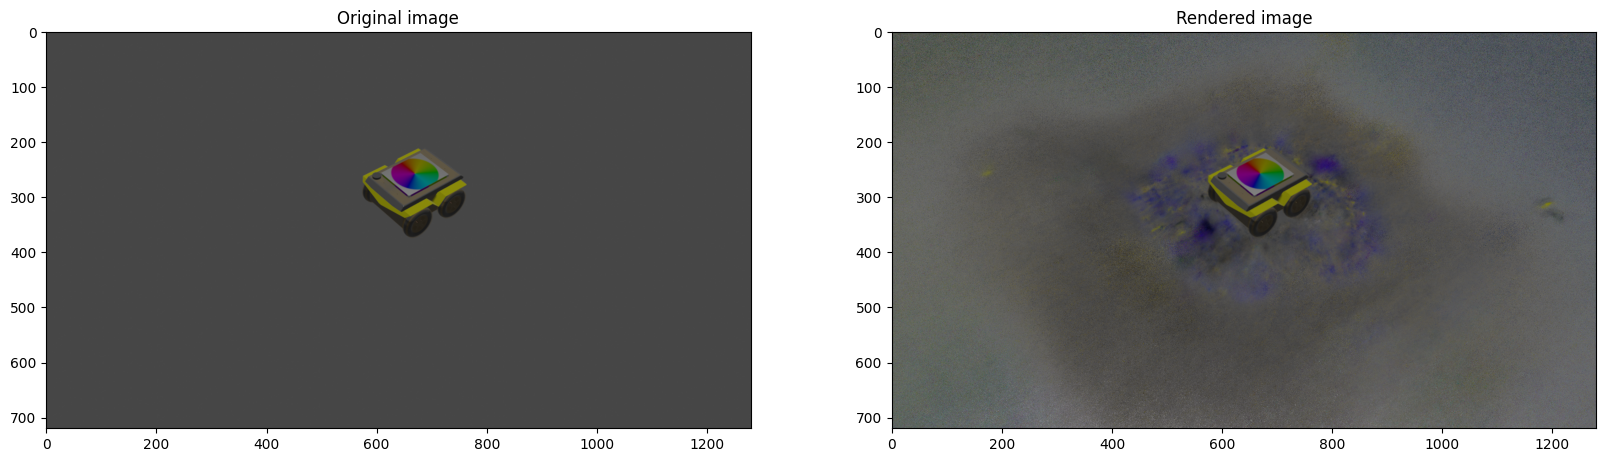

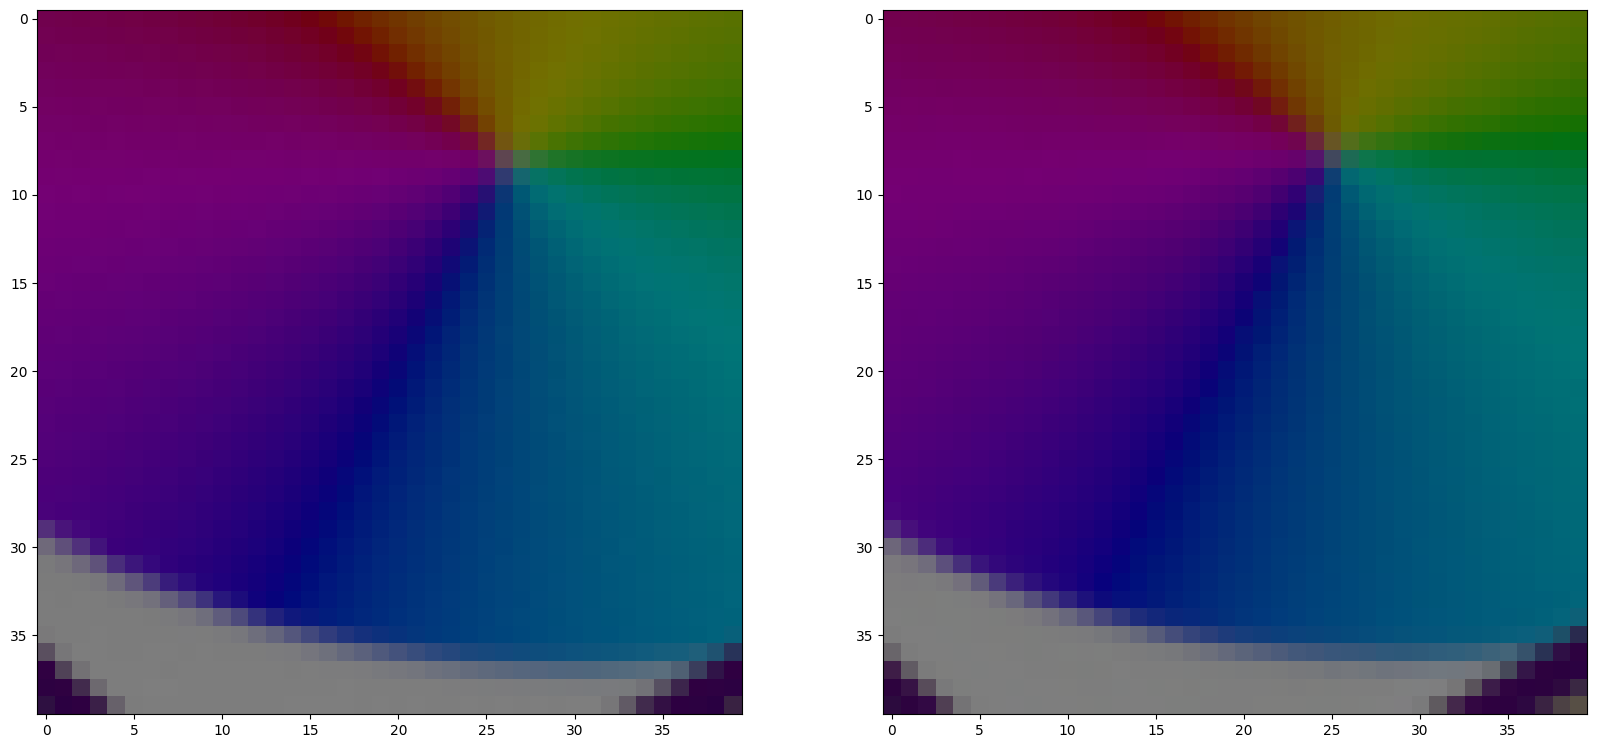

In [22]:
#Plot original image and rendered image
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(original_img)
ax[0].set_title("Original image")
ax[1].imshow(rendered_img)
ax[1].set_title("Rendered image")
#Plot [270,663] and [663,270] pixel in the rendered image
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(original_img[270-20:270+20,663-20:663+20])
ax[1].imshow(rendered_img[270-20:270+20,663-20:663+20])


In [10]:
if False:
    camera = trainer.pipeline.datamanager.train_dataparser_outputs.cameras.camera_to_worlds.to(trainer.pipeline.device)
    correction = trainer.pipeline.model.camera_optimizer.forward([i for i in range(trainer.pipeline.datamanager.train_dataparser_outputs.cameras.camera_to_worlds.shape[0])]) #WARNING: We are only getting the first pose
    centred_pose = correct_pose(camera, correction)
    print(centred_pose)

In [11]:
#Sample at fix intervals
store = torch.tensor([])
all_frames = []

for theta in range(-180, 180, 10):
    break
    #Create Rotation matrix about z axis
    rotation_matrix = torch.tensor(Rotation.from_rotvec(np.array([0, 0, theta]), degrees=True).as_matrix(), device=trainer.pipeline.device,dtype=torch.float32)

    #Apply to current camera
    #trainer.pipeline.datamanager.train_dataparser_outputs.cameras.camera_to_worlds = (rotation_matrix @ centred_pose).to(trainer.pipeline.device)
    trainer.pipeline.datamanager.train_dataparser_outputs.cameras.camera_to_worlds = (rotation_matrix @ ground_truth_poses_in_trainer.to(trainer.pipeline.device)).to(trainer.pipeline.device)

    trainer.pipeline.train()
    loss = trainer.get_loss()

    corrected_pose = get_corrected_pose(trainer)
    relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
    t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)
    #Get averrage absolute translation and rotation error
    print("Average translation error: ", torch.mean(t_diff))
    print("Average rotation error: ", torch.mean(r_diff))
    print(loss)

    store = torch.cat((store, torch.tensor([[theta, loss["rgb_loss"], loss["pixel_loss"][0], loss["close_pixels"]]])), 0)


    if False:
        corrected_pose = get_corrected_pose(trainer)
        print(corrected_pose)
        original_img = cv2.imread(os.path.join(DATA_PATH, GROUND_TRUTH["frames"][0]["file_path"]))
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        rendered_img = get_image(trainer.pipeline, corrected_pose[0:1,:,:])
        rendered_img = rendered_img["rgb"]

        all_frames.append(rendered_img)



In [12]:
#Plot the loss
plt.plot(store[:,0], store[:,3])
#plt.plot(store[:,0], store[:,2])
plt.xlabel("Rotation about z axis")
plt.ylabel("Loss")

IndexError: too many indices for tensor of dimension 1

In [ ]:
batch = trainer.pipeline.datamanager.inerf_batch
ray_bundle = trainer.pipeline.datamanager.train_ray_generator(batch["indices"])

#Create blank 2D array
image = np.zeros((720, 1280, 3), dtype=np.float32)
cnt = np.zeros((720, 1280, 1), dtype=np.float32)

for i in range(len(batch['image'])):
    x,y = batch['indices'][i,1:]
    cnt[x,y] += 1
    image[x,y] = batch['image'][i,:3]

In [ ]:
print(image[270,663]*255)

[  9.   6. 119.]


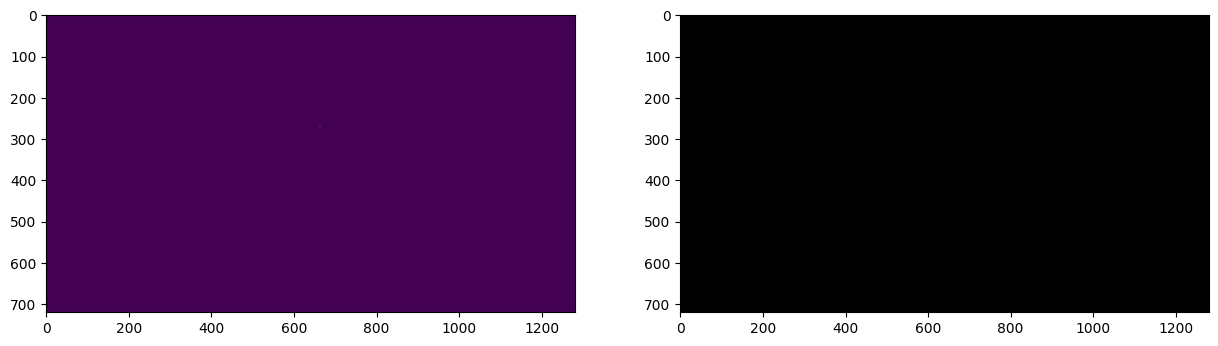

In [ ]:
# Plot cnt and image in subplot
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(cnt)
ax[1].imshow(image)
plt.show()

IndexError: list index out of range

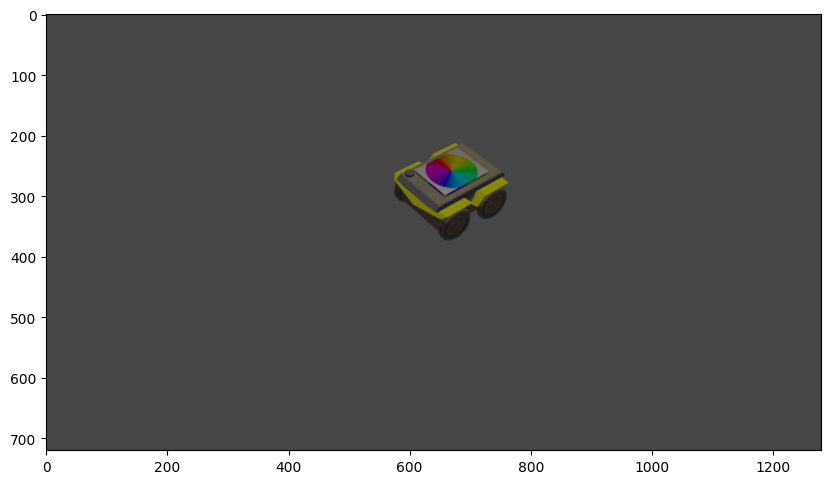

In [ ]:
#Overlay original image and rendered image
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(original_img)
ax.imshow(all_frames[3], alpha=0.5)